In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline


In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
print(f'stoi: {stoi}')
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(f'itos: {itos}')
print(f'Size: {vocab_size}')

stoi: {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}
itos: {1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
Size: 27


In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) 
b1 = torch.randn(n_hidden,                        generator=g) 
W2 = torch.randn((n_hidden, vocab_size),          generator=g) 
b2 = torch.randn(vocab_size,                      generator=g) 

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11897


In [7]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    #forward pass
    emb = C[Xb]
    embcat = emb.view(Xb.shape[0], -1)
    hpreact = embcat@W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = 0.1 if i<100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad


    # track stats
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():4f}")
    lossi.append(loss.log10().item())

      0/ 200000: 27.881727
  10000/ 200000: 2.805013
  20000/ 200000: 2.551838
  30000/ 200000: 2.803529
  40000/ 200000: 2.047602
  50000/ 200000: 2.703313
  60000/ 200000: 2.317933
  70000/ 200000: 2.096592
  80000/ 200000: 2.334373
  90000/ 200000: 2.215454
 100000/ 200000: 2.071170
 110000/ 200000: 2.408605
 120000/ 200000: 1.866091
 130000/ 200000: 2.310305
 140000/ 200000: 2.234986
 150000/ 200000: 2.174228
 160000/ 200000: 2.118977
 170000/ 200000: 1.757867
 180000/ 200000: 2.018282
 190000/ 200000: 1.818594


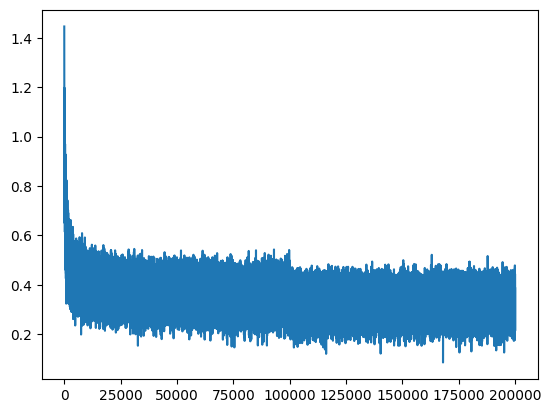

In [8]:
plt.plot(lossi)

In [9]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'test': (Xte, Yte),
        'val': (Xdev, Ydev),
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    h = torch.tanh(embcat@W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

In [10]:
# split_loss('test')
split_loss('train')
split_loss('val')

train 2.1256532669067383
val 2.1684703826904297


## Issue #1  Initial Loss is much higher than assigning equal probability to each letter.

In [11]:
# logits = torch.tensor([0.25, 0.25, 0.25, 0.25])
logits = torch.randn(4) * 100 # more if 10x or 100x
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
logits, probs, loss

(tensor([-17.6151,  70.5347, 113.6380,   2.7914]),
 tensor([0.0000e+00, 1.9075e-19, 1.0000e+00, 0.0000e+00]),
 tensor(-0.))

### Make b2 0 at initialization and W2 smaller to get lower logits in first iteration. So logits don't take extreme values in first iteration

In [12]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) 
b1 = torch.randn(n_hidden,                        generator=g) 
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0 

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11897


In [13]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    #forward pass
    emb = C[Xb]
    embcat = emb.view(Xb.shape[0], -1)
    hpreact = embcat@W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = 0.1 if i<100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad


    # track stats
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():4f}")
    lossi.append(loss.log10().item())
    

      0/ 200000: 3.322059
  10000/ 200000: 2.189968
  20000/ 200000: 2.419572
  30000/ 200000: 2.606707
  40000/ 200000: 2.060104
  50000/ 200000: 2.498806
  60000/ 200000: 2.390249
  70000/ 200000: 2.134383
  80000/ 200000: 2.336876
  90000/ 200000: 2.129889
 100000/ 200000: 1.832913
 110000/ 200000: 2.205288
 120000/ 200000: 1.853989
 130000/ 200000: 2.456578
 140000/ 200000: 2.187871
 150000/ 200000: 2.111785
 160000/ 200000: 1.895567
 170000/ 200000: 1.864450
 180000/ 200000: 2.032571
 190000/ 200000: 1.841691


In [14]:
logits[0]

tensor([-1.0116,  2.1188, -0.9094, -1.7597, -0.6279,  2.2488, -1.7702, -1.4846,
        -0.5791,  2.8137, -1.0657, -1.6277,  2.5374,  1.6568,  3.6743,  1.5285,
        -0.2121, -4.8728,  1.9167,  1.3215,  0.7041, -0.7861,  0.7667, -2.0711,
        -4.5283,  2.6771,  0.0309], grad_fn=<SelectBackward0>)

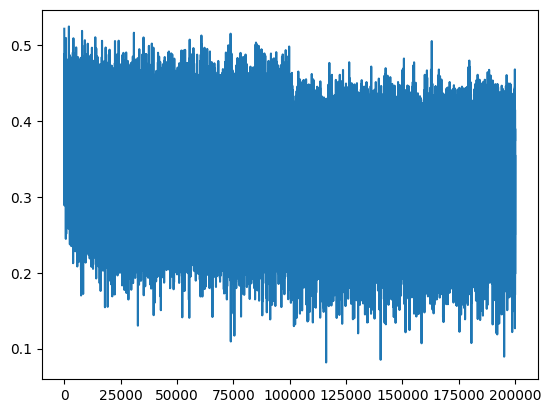

In [15]:
plt.plot(lossi)  # good news, no hockey shape

In [16]:

# split_loss('test')
split_loss('train')
split_loss('val')
    

train 2.0695888996124268
val 2.131074905395508


### Issue #2 Tanh is very active. Activation Layers take extreme values a lot of time

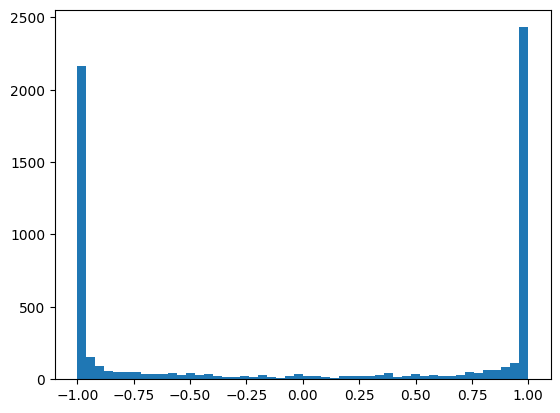

In [17]:
plt.hist(h.view(-1).tolist(), 50);   # most of the values are closer to -1 or 1

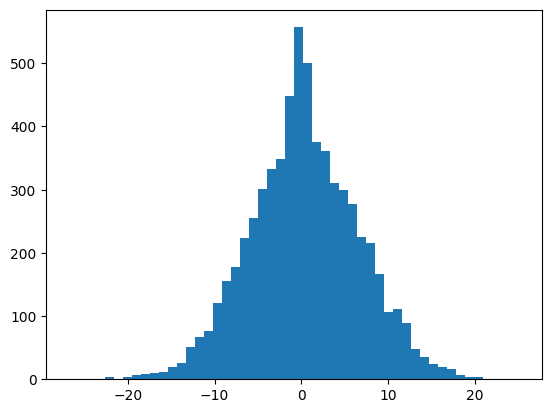

In [18]:
plt.hist(hpreact.view(-1).tolist(), 50);

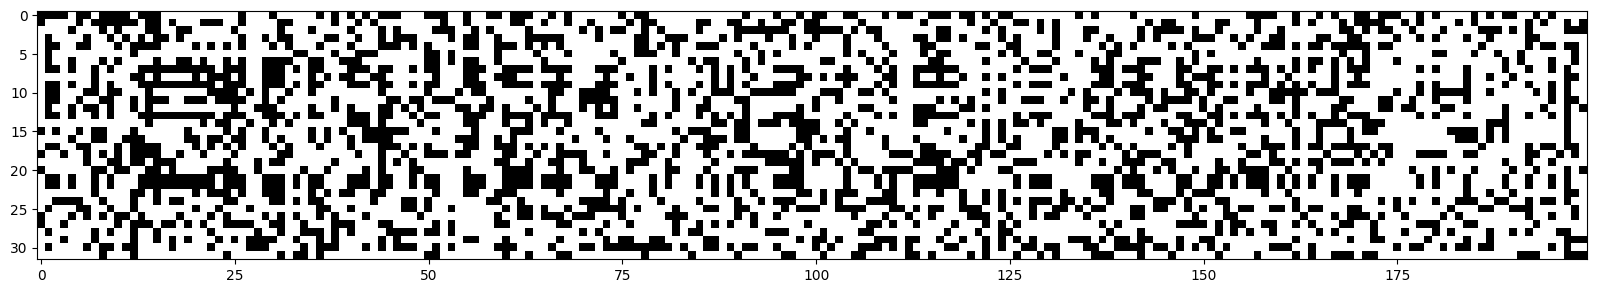

In [19]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs()> 0.99, cmap='gray', interpolation='nearest')

# white- true, black-false, if there was a column with full white would mean dead neuron

In [20]:
# same issue could also happen during gradient update,
# if learning rate is not good, gradient update could give weights extreme values and tanh would knock them out and network would not learn, 
# kind of similar to brain damange  🧐

In [21]:
# solution would be reduce hpreact so make w1 and b1 smaller and closer to 0

In [22]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.2
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0 

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11897


In [23]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    #forward pass
    emb = C[Xb]
    embcat = emb.view(Xb.shape[0], -1)
    hpreact = embcat@W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = 0.1 if i<100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad


    # track stats
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():4f}")
    lossi.append(loss.log10().item())
    # break
    

      0/ 200000: 3.313459
  10000/ 200000: 2.164827
  20000/ 200000: 2.306087
  30000/ 200000: 2.454139
  40000/ 200000: 1.978676
  50000/ 200000: 2.292973
  60000/ 200000: 2.423234
  70000/ 200000: 2.067997
  80000/ 200000: 2.309542
  90000/ 200000: 2.120710
 100000/ 200000: 1.826862
 110000/ 200000: 2.204487
 120000/ 200000: 1.979659
 130000/ 200000: 2.394568
 140000/ 200000: 2.100044
 150000/ 200000: 2.194798
 160000/ 200000: 1.861942
 170000/ 200000: 1.780918
 180000/ 200000: 1.967285
 190000/ 200000: 1.829464


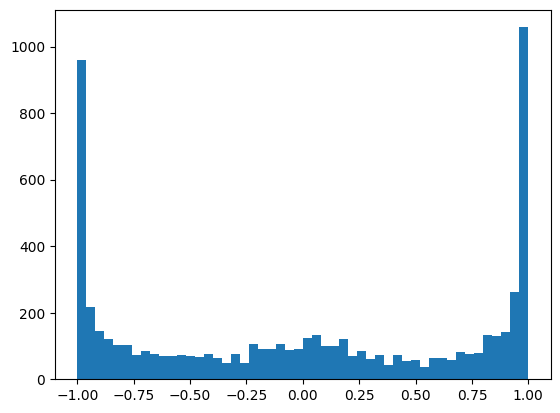

In [24]:
plt.hist(h.view(-1).tolist(), 50);   # values are not close to -1 or 1 now

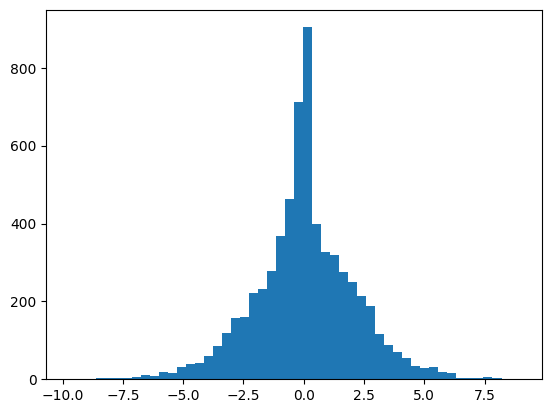

In [25]:
plt.hist(hpreact.view(-1).tolist(), 50); # same here range is lower

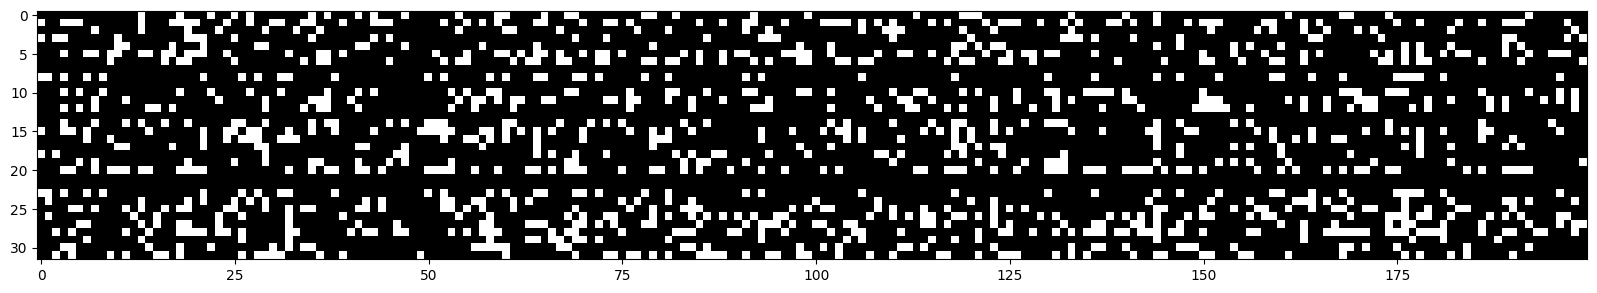

In [26]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs()> 0.99, cmap='gray', interpolation='nearest')

# white- true, black-false, if there was a column with full white would mean dead neuron

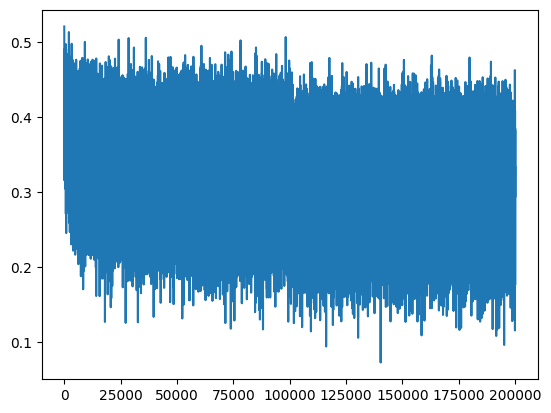

In [27]:
plt.plot(lossi);

In [28]:
split_loss('train')
split_loss('val')

train 2.0355966091156006
val 2.1026785373687744


### Methodology behind finding multiplier that will limit the gaussian spread

tensor(0.0032) tensor(1.0055)
tensor(-0.0135) tensor(0.9753)
tensor(0.0055) tensor(3.0978)


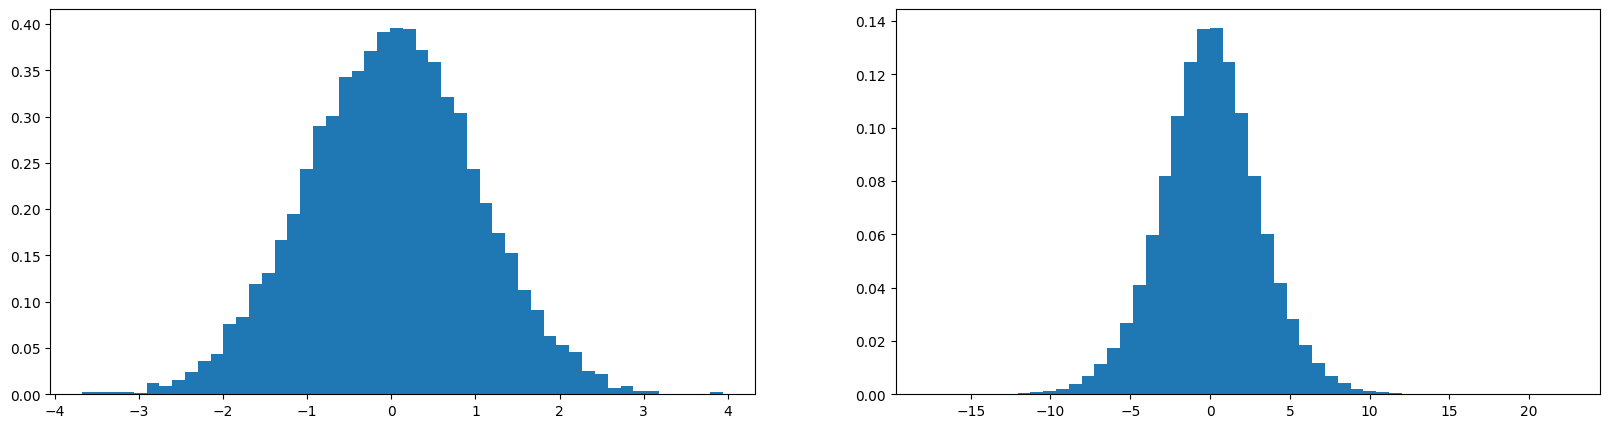

In [41]:
x = torch.randn(1000, 10) #uniform gaussian
w = torch.randn(10, 200) # uniform gaussian
y = x @ w
print(x.mean(), x.std())
print(w.mean(), w.std())
print(y.mean(), y.std())

# standard deviation increases on multiplying but mean remains same so we need to downscale weights to remain uniform gaussian and keep standard deviation same.
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

tensor(0.0218) tensor(0.9948)
tensor(-0.0151) tensor(0.3160)
tensor(-0.0014) tensor(0.9963)


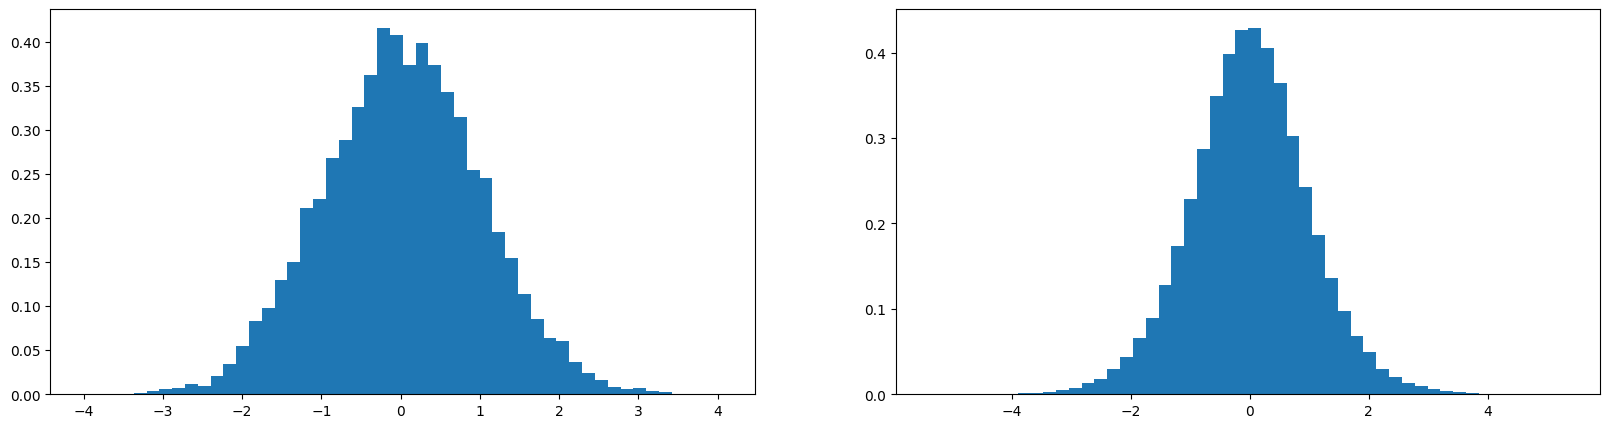

In [45]:
## To find what to multiply to keep multiplication same as uniform gaussian, use Kaiming method. i.e. sqrt of fan_in

x = torch.randn(1000, 10) #uniform gaussian
w = torch.randn(10, 200) / 10**0.5 # uniform gaussian 
y = x @ w
print(x.mean(), x.std())
print(w.mean(), w.std())
print(y.mean(), y.std())

# now standard deviation remains almost same 

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

In [46]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)   # kaiming method
b1 = torch.randn(n_hidden,                        generator=g) * 0.01   # make tanh activation 
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01   # reduce initial randomness
b2 = torch.randn(vocab_size,                      generator=g) * 0      # reduce intial randomness

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11897


In [47]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    #forward pass
    emb = C[Xb]
    embcat = emb.view(Xb.shape[0], -1)
    hpreact = embcat@W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = 0.1 if i<100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad


    # track stats
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():4f}")
    lossi.append(loss.log10().item())
    # break
    

      0/ 200000: 3.317901
  10000/ 200000: 2.191044
  20000/ 200000: 2.327004
  30000/ 200000: 2.539579
  40000/ 200000: 1.946813
  50000/ 200000: 2.333054
  60000/ 200000: 2.385176
  70000/ 200000: 2.117301
  80000/ 200000: 2.315899
  90000/ 200000: 2.201018
 100000/ 200000: 1.859077
 110000/ 200000: 2.088105
 120000/ 200000: 1.938938
 130000/ 200000: 2.391335
 140000/ 200000: 2.094917
 150000/ 200000: 2.145783
 160000/ 200000: 1.782431
 170000/ 200000: 1.724870
 180000/ 200000: 1.975150
 190000/ 200000: 1.861384


In [49]:
split_loss('train')
split_loss('val')

train 2.0376641750335693
val 2.106989622116089


In [52]:
# loss log

# original 
# train 2.1256532669067383
# val 2.1684703826904297

# fix softmax confidentaly wrong
# train 2.0695888996124268
# val 2.131074905395508


# fix tanh layer too saturated at initialzation, using kaiming method
# train 2.0376641750335693
# val 2.106989622116089


### Batch Normalization

In [69]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)   # kaiming method
# b1 = torch.randn(n_hidden,                        generator=g) * 0.01   # make tanh activation  # bias is not needed anymore as it gets cancelled in batch norm and batch norm has it's own bias
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01   # reduce initial randomness
b2 = torch.randn(vocab_size,                      generator=g) * 0      # reduce intial randomness

#batch normalization parameters
bn_gain = torch.ones((1, n_hidden))
bn_bias = torch.zeros((1, n_hidden))

# buffers which are not part of parameters and only used at inference
bnmean_running = torch.zeros((1, n_hidden))  
bnstd_running = torch.ones((1, n_hidden))


parameters = [C, W1, W2, b2, bn_gain, bn_bias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


In [75]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    #forward pass
    emb = C[Xb]      # embed the characters into vectors
    embcat = emb.view(Xb.shape[0], -1)  # concatenate the vectors
    
    #linear layer
    hpreact = embcat@W1 #  hidden layer preactivation
    
    # Batch Normalization Layer
    # -----------------------------------------------
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bn_gain * (hpreact - bnmeani) / bnstdi + bn_bias     # normalize activation layer
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani    # 0.99, 0.01 are called momentum
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    
    # -----------------------------------------------
    
    # non-linearity using tanh
    
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2    # output layer
    loss = F.cross_entropy(logits, Yb)   # loss function

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = 0.1 if i<100000 else 0.01 # step rate decay
    for p in parameters:
        p.data += -lr * p.grad


    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f"{i:7d}/{max_steps:7d}: {loss.item():4f}")
    lossi.append(loss.log10().item())
    # break
    

      0/ 200000: 2.186173
  10000/ 200000: 1.982230
  20000/ 200000: 2.390049
  30000/ 200000: 2.115110
  40000/ 200000: 2.166818
  50000/ 200000: 2.086448
  60000/ 200000: 2.260300
  70000/ 200000: 2.309531
  80000/ 200000: 2.186110
  90000/ 200000: 1.925758
 100000/ 200000: 2.100452
 110000/ 200000: 2.366812
 120000/ 200000: 1.979024
 130000/ 200000: 1.697135
 140000/ 200000: 1.942159
 150000/ 200000: 2.021076
 160000/ 200000: 1.860206
 170000/ 200000: 1.784062
 180000/ 200000: 1.995632
 190000/ 200000: 2.147799


In [71]:
# update evaluation method to accomodate batch normalization
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'test': (Xte, Yte),
        'val': (Xdev, Ydev),
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat@W1
    hpreact = bn_gain * ( hpreact - bnmean_running) / (bnstd_running) + bn_bias 
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

In [72]:
split_loss('train')
split_loss('val')

train 2.067383289337158
val 2.106067180633545


In [74]:
# loss log

# original 
# train 2.1256532669067383
# val 2.1684703826904297

# fix softmax confidentaly wrong
# train 2.0695888996124268
# val 2.131074905395508


# fix tanh layer too saturated at initialzation, using kaiming method
# train 2.0376641750335693
# val 2.106989622116089


# Batch normalization
# train 2.067383289337158
# val 2.106067180633545